In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
import cv2
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_score
from matplotlib import pyplot as plt
from scipy.stats import uniform, randint, expon, loguniform
import seaborn as sns
sns.set()


In [19]:
df=pd.read_csv(r"E:\machinelearning\data\train.csv")
a,b=np.unique(df["target"],return_counts=True)
from sklearn.model_selection import train_test_split

train,valid=train_test_split(df,test_size=0.2)
train,test=train_test_split(train,test_size=0.01)

train["image_name_jpg"]=train["image_name"]+".jpg"
test["image_name_jpg"]=test["image_name"]+".jpg"
valid["image_name_jpg"]=valid["image_name"]+".jpg"

train["target"]=train["target"].astype(str)
test["target"]=test["target"].astype(str)
valid["target"]=valid["target"].astype(str)

In [20]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=False
    )
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)


train_generator =train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=r"E:/machinelearning/data/train/",
    x_col="image_name_jpg", # name +".jpg"
    y_col="target",
    target_size=(255,255),
    batch_size=32,
    class_mode="binary"
)

Found 26235 validated image filenames belonging to 2 classes.


In [21]:
validation_generator =test_datagen.flow_from_dataframe(
    dataframe=valid,
    directory=r"E:/machinelearning/data/train/",
    x_col="image_name_jpg",
    y_col="target",
    target_size=(255,255),
    batch_size=16,
    class_mode="binary"
)

Found 6626 validated image filenames belonging to 2 classes.


In [22]:
train_generator.reset()
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)
for i in tqdm(range(int(len(train_generator))-1)): #1st batch is already fetched before the for loop.
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 819/819 [02:55<00:00,  4.66it/s]

(26235, 64, 64, 3) (26235,)


In [23]:
validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in tqdm(range(int(len(validation_generator))-1)): #1st batch is already fetched before the for loop.
  img, label = next(validation_generator)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

100%|██████████| 414/414 [00:25<00:00, 16.00it/s]

(6626, 64, 64, 3) (6626,)


In [24]:
X_train = X_train.reshape(26235,3*255*255)
X_test = X_test.reshape(6626,3*255*255)
print(X_train.shape, X_test.shape)

(26235, 12288) (6626, 12288)


In [25]:
kf = StratifiedKFold(n_splits=10, random_state=233, shuffle=True)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

gaussian_parametros = {'gaussian__var_smoothing': [1e-11, 1e-10, 1e-9]}
pipe = Pipeline([('scaler', StandardScaler()), ('gaussian', GaussianNB())])


gaussian_best_model = RandomizedSearchCV(pipe, gaussian_parametros, n_iter=3, cv=kf, refit=True)
gaussian_best_model = gaussian_best_model.fit(X_train, y_train)
gaussian_yfit = gaussian_best_model.predict(X_test)

print(classification_report(y_test, gaussian_yfit))

              precision    recall  f1-score   support

         0.0       0.99      0.67      0.80      6504
         1.0       0.03      0.60      0.06       122

    accuracy                           0.67      6626
   macro avg       0.51      0.64      0.43      6626
weighted avg       0.97      0.67      0.79      6626



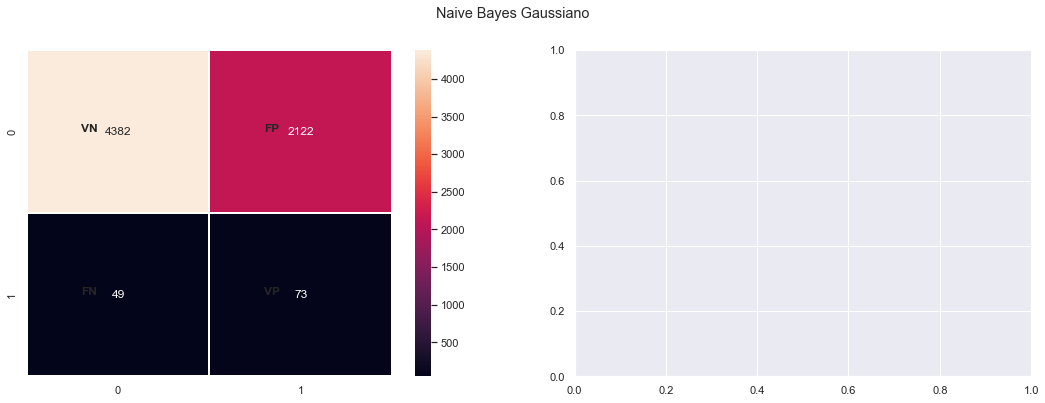

In [37]:
matrix_confusion = confusion_matrix(y_test, gaussian_yfit)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
fig.suptitle("Naive Bayes Gaussiano")
sns.heatmap(matrix_confusion,annot=True, fmt='g', linewidth=0.3,cbar=True, ax=axes[0])
        
axes[0].annotate('VN', (0.3,0.5), fontweight='bold')
axes[0].annotate('FP', (1.3,0.5), fontweight='bold')
axes[0].annotate('FN', (0.3,1.5), fontweight='bold')
axes[0].annotate('VP', (1.3,1.5), fontweight='bold')


plt.show()

In [195]:
from sklearn import svm
from sklearn.svm import SVC

svm_params = {
    "svm__degree": randint(2,3)
}


pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True))])
svm_best_model = RandomizedSearchCV(pipe, svm_params, n_iter=1, cv=kf, refit=True)
svm_best_model = svm_best_model.fit(X_train, y_train)
svm_yfit = svm_best_model.predict(X_test)


print(classification_report(y_test, svm_yfit))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      6518
         1.0       0.00      0.00      0.00       108

    accuracy                           0.98      6626
   macro avg       0.49      0.50      0.50      6626
weighted avg       0.97      0.98      0.98      6626



C:\Users\helio\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\helio\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\helio\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


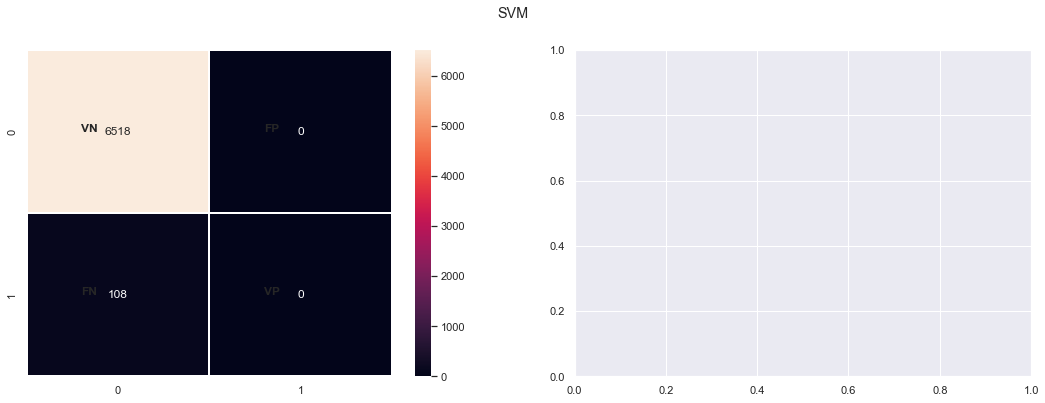

In [197]:
matrix_confusion = confusion_matrix(y_test, svm_yfit)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
fig.suptitle("SVM")
sns.heatmap(matrix_confusion,annot=True, fmt='g', linewidth=0.3,cbar=True, ax=axes[0])
        
axes[0].annotate('VN', (0.3,0.5), fontweight='bold')
axes[0].annotate('FP', (1.3,0.5), fontweight='bold')
axes[0].annotate('FN', (0.3,1.5), fontweight='bold')
axes[0].annotate('VP', (1.3,1.5), fontweight='bold')


plt.show()

In [27]:
from sklearn import svm
from sklearn.svm import SVC

svm_params = {
    "svm__C": loguniform(1e-4, 1e2),
    "svm__kernel": ["poly","rbf","linear"],
    "svm__degree": randint(2,4),
    "svm__gamma": loguniform(1e-4, 1e2), 
}


pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True))])
svm_best_model = RandomizedSearchCV(pipe, svm_params, n_iter=3, cv=kf, refit=True)
svm_best_model = svm_best_model.fit(X_train, y_train)
svm_yfit = svm_best_model.predict(X_test)


print(classification_report(y_test, svm_yfit))

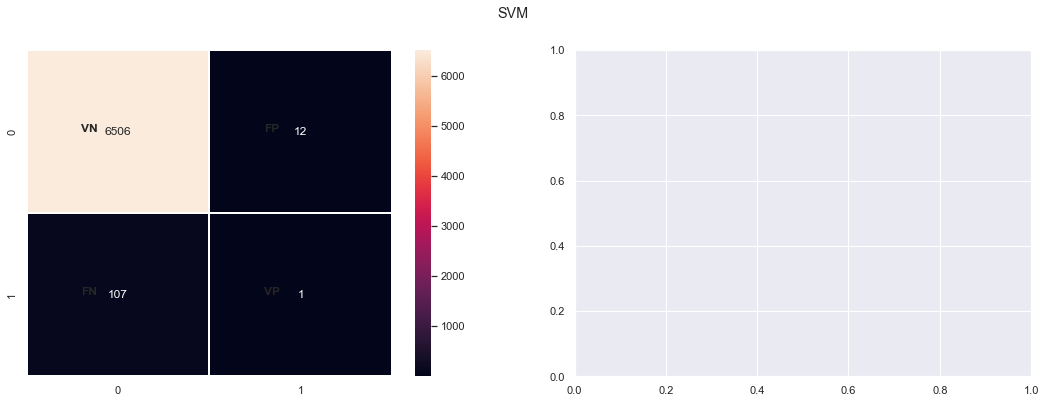

In [208]:
matrix_confusion = confusion_matrix(y_test, svm_yfit)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
fig.suptitle("SVM")
sns.heatmap(matrix_confusion,annot=True, fmt='g', linewidth=0.3,cbar=True, ax=axes[0])
        
axes[0].annotate('VN', (0.3,0.5), fontweight='bold')
axes[0].annotate('FP', (1.3,0.5), fontweight='bold')
axes[0].annotate('FN', (0.3,1.5), fontweight='bold')
axes[0].annotate('VP', (1.3,1.5), fontweight='bold')


plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_parametros = {
    "knn__n_neighbors": randint(1, 50),
}

pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_best_model = RandomizedSearchCV(pipe, knn_parametros,n_iter=5, cv=kf, refit=True)
knn_best_model = knn_best_model.fit(X_train, y_train)
knn_yfit = knn_best_model.predict(X_test)

print(classification_report(y_test, knn_yfit))

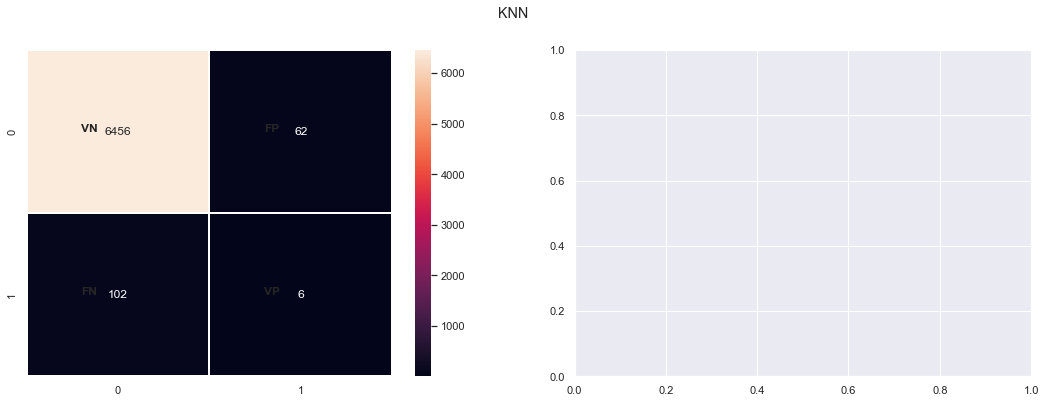

In [190]:

matrix_confusion = confusion_matrix(y_test, knn_yfit)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
fig.suptitle("KNN")
sns.heatmap(matrix_confusion,annot=True, fmt='g', linewidth=0.3,cbar=True, ax=axes[0])
        
axes[0].annotate('VN', (0.3,0.5), fontweight='bold')
axes[0].annotate('FP', (1.3,0.5), fontweight='bold')
axes[0].annotate('FN', (0.3,1.5), fontweight='bold')
axes[0].annotate('VP', (1.3,1.5), fontweight='bold')


plt.show()

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree_parametros = {
    "tree__criterion": ["gini", "entropy"],
    "tree__splitter": ["best", "random"],
    "tree__min_samples_split": uniform(loc=0, scale=1),
    "tree__min_samples_leaf":  uniform(loc=1e-6, scale=0.5),
    "tree__max_leaf_nodes": randint(1, 1000),
    "tree__max_depth": randint(1, 1000),
}

pipe = Pipeline([('scaler', StandardScaler()), ('tree', DecisionTreeClassifier())])
tree_best_model = RandomizedSearchCV(pipe, tree_parametros,n_iter=1, cv=kf, refit=True)
tree_best_model = tree_best_model.fit(X_train, y_train)
tree_yfit = tree_best_model.predict(X_test)


print(classification_report(y_test, tree_yfit))


              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      6518
         1.0       0.07      0.04      0.05       108

    accuracy                           0.98      6626
   macro avg       0.53      0.51      0.52      6626
weighted avg       0.97      0.98      0.97      6626



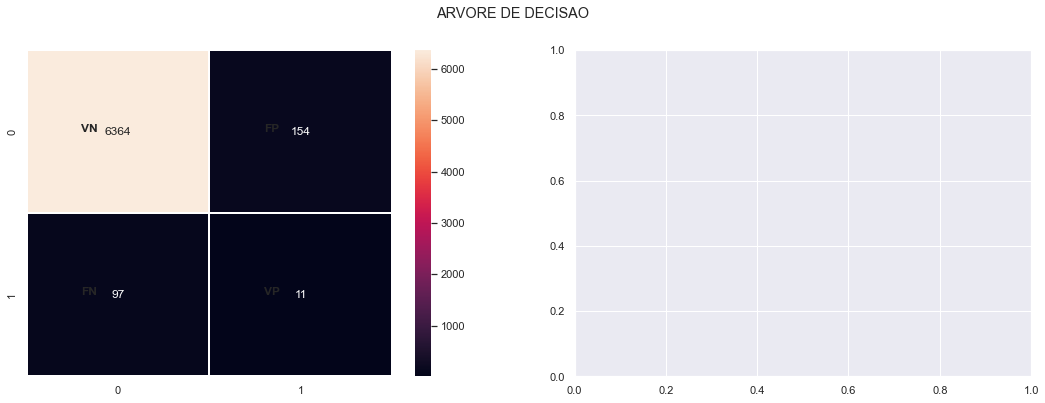

In [14]:
matrix_confusion = confusion_matrix(y_test, tree_yfit)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
fig.suptitle("ARVORE DE DECISAO")
sns.heatmap(matrix_confusion,annot=True, fmt='g', linewidth=0.3,cbar=True, ax=axes[0])
        
axes[0].annotate('VN', (0.3,0.5), fontweight='bold')
axes[0].annotate('FP', (1.3,0.5), fontweight='bold')
axes[0].annotate('FN', (0.3,1.5), fontweight='bold')
axes[0].annotate('VP', (1.3,1.5), fontweight='bold')


plt.show()